In [1]:
import torch
import json
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch
from PIL import Image
import pickle

In [5]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16) 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device);

cuda


In [7]:
f = open('questions/val_balanced_questions.json')
data = json.load(f)

In [8]:
f = open('questions/val_all_questions.json')
data_ref = json.load(f)

In [9]:
dev_val = {}
# n = 10000
for k,v in data.items():
    dev_val[k]=v
    for qid in v['entailed']:
        dev_val[qid] = data_ref[qid]
    # n -= 1
    # if n == 0:
    #     break

with open("final_questions.json", 'w') as f:
    json.dump(dev_val, f)

f = open('final_questions.json')
new_data = json.load(f)

In [10]:
def get_data(qid, data):
    image = data[qid]['imageId']
    question = data[qid]['question']
    answer = data[qid]['answer']
    full_answer = data[qid]['fullAnswer']
    entailed = data[qid]['entailed']
    return image, question, answer, full_answer, entailed


image, question, answer, full_answer, entailed = get_data('08223573', new_data)

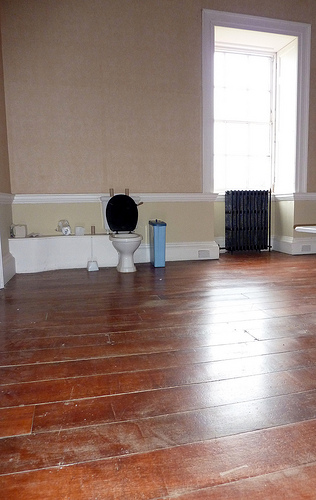

In [11]:
image = Image.open('images/'+image+'.jpg')
display(image)

In [12]:
question_formatted = f'Answer the following question with one word. Question: {question} Answer:' 
print(question_formatted)

Answer the following question with one word. Question: Is it an indoors or outdoors scene? Answer:


In [13]:
inputs = processor(image, text=question_formatted, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Indoor


In [18]:
%%time
# questions = {}
# answers = {}
# ground_truth = {}
# # captions = {}
# full_ground_truth = {}

for i, k in enumerate(list(new_data.keys())):
    if (i+1) % 5000 == 0:
        print(i+1)
        # dictionaries = {'questions.pkl': questions, 'answers.pkl': answers, 
        #         'ground_truth.pkl': ground_truth, 'full_ground_truth.pkl': full_ground_truth}

        # for filename, dictionary in dictionaries.items():
        #     with open(filename, 'wb') as file:
        #         pickle.dump(dictionary, file)

    if k not in questions:
        image, question, answer, full_answer, entailed = get_data(k, new_data)
    
        # entailed.append(k)
    
        image = Image.open('images/'+image+'.jpg')
        
        question_formatted = f'Answer the following question with one word. Question: {question} Answer:' 
        inputs = processor(image, text=question_formatted, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    
        # inputs = processor(image, return_tensors="pt").to(device, torch.float16)
        # generated_ids = model.generate(**inputs, max_new_tokens=20)
        # caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    
        answers[k] = generated_text.lower()
        questions[k] = question
        ground_truth[k] = answer
        full_ground_truth[k] = full_answer
        # print(question, generated_text.lower(), answer)
        # captions[k] = caption




5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
CPU times: user 6h 28min 9s, sys: 1min 59s, total: 6h 30min 9s
Wall time: 3h 31min 2s


In [15]:
len(new_data)

480325

In [21]:
import pickle
import json

pkl_file_path = 'answers.pkl'

json_file_path = 'val_predictions.json'

with open(pkl_file_path, 'rb') as file:
    pkl_data = pickle.load(file)

json_data = [{"questionId": key, "prediction": value} for key, value in pkl_data.items()]

with open(json_file_path, 'w') as file:
    json.dump(json_data, file, indent=4)
with open('questions.json', 'w') as file:
    json.dump(new_data, file, indent=4)


In [4]:
len(pkl_data)

349999

In [14]:
files= ['answers.pkl', 'questions.pkl', 'ground_truth.pkl', 'full_ground_truth.pkl']


for i, file in enumerate(files):
    with open(file, 'rb') as file:
        if i == 0:
            answers = pickle.load(file)
        if i == 1:
            questions = pickle.load(file)
        if i == 2:
            ground_truth = pickle.load(file)
        if i == 3:
            full_ground_truth = pickle.load(file)



In [19]:
dictionaries = {'questions.pkl': questions, 'answers.pkl': answers, 
        'ground_truth.pkl': ground_truth, 'full_ground_truth.pkl': full_ground_truth}

for filename, dictionary in dictionaries.items():
    with open(filename, 'wb') as file:
        pickle.dump(dictionary, file)


In [20]:
len(questions)

480325

In [34]:
new_data['05515936']

{'semantic': [{'operation': 'select',
   'dependencies': [],
   'argument': 'bird (329774)'},
  {'operation': 'query', 'dependencies': [0], 'argument': 'name'}],
 'entailed': ['05515938', '05515937', '05515922', '05515921'],
 'equivalent': ['05515936'],
 'question': 'Which bird is in the image?',
 'imageId': '2405722',
 'isBalanced': False,
 'groups': {'global': 'bird', 'local': '11q-bird'},
 'answer': 'parrot',
 'semanticStr': 'select: bird (329774)->query: name [0]',
 'annotations': {'answer': {'0': '329774'},
  'question': {'1': '329774'},
  'fullAnswer': {'1': '329774', '4': '329774'}},
 'types': {'detailed': 'category', 'semantic': 'cat', 'structural': 'query'},
 'fullAnswer': 'The bird is a parrot.'}

In [44]:
tot = 0
for key, answer in answers.items():
    if ' ' in answer:
        tot += 1
tot/len(answers)

0.21669286420652684